# **User-based рекомендационная система**

# Матричная факторизация

Для использования user-based метода из начальных данных создается матрица, где строки - это пользователи, столбцы - фильмы (или другие товары) и в ячейках расставляются оценки. В реальности почти не возможно, чтобы у пользователя были выставлены оценки на все фильмы (товары), поэтому можно использовать факторизацию для предсказания оценок пользователей, даже если они не взаимодействовали с определёнными объектами.

факторизация с ограничением на неотрицательные значения

In [ ]:
#NMF (Non-Negative Matrix Factorization)
from sklearn.decomposition import NMF

# Создаём модель NMF
nmf = NMF(n_components=3, init='random', l1_ratio=0.1)

# Применяем факторизацию
X_transformed = nmf.fit_transform(data.data)

# Выводим восстановленные значения
print(nmf.inverse_transform(X_transformed[0]))


разложение матрицы на три компонента, помогает снизить размерность данных

In [ ]:
#SVD (Singular Value Decomposition)
import numpy as np
from scipy.linalg import svd

# Создаём случайную матрицу
matrix = np.random.rand(5, 4)

# Применяем SVD
U, S, Vt = svd(matrix)

print("U:", U)
print("S:", S)
print("Vt:", Vt)

# Нормализация оценок

Поскольку пользователи могут иметь разные стили оценивания (одни всегда ставят высокие баллы, другие – низкие), часто применяется нормализация (например, вычитание среднего рейтинга пользователя) до вычисления сходства

**Нормализация по среднему (Mean Centering)**

Для каждого пользователя вычисляют среднее значение его оценок и вычитают его из каждой оценки

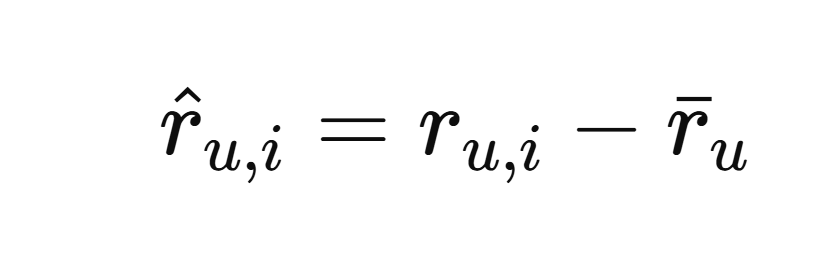

In [ ]:
def mean_centering(ratings):
    """
    ratings: список оценок для одного пользователя
    возвращает список оценок, нормализованных путем вычитания среднего значения.
    """
    mean = sum(ratings) / len(ratings)
    return [r - mean for r in ratings]

# Пример
user_ratings = [4, 5, 3, 2]
normalized = mean_centering(user_ratings)
print(normalized)

**Z-нормализация (z-score normalization)**

Приводят оценки к стандартному виду, вычитая среднее и деля на стандартное отклонение. Так каждая оценка выражается в единицах отклонения от среднего.

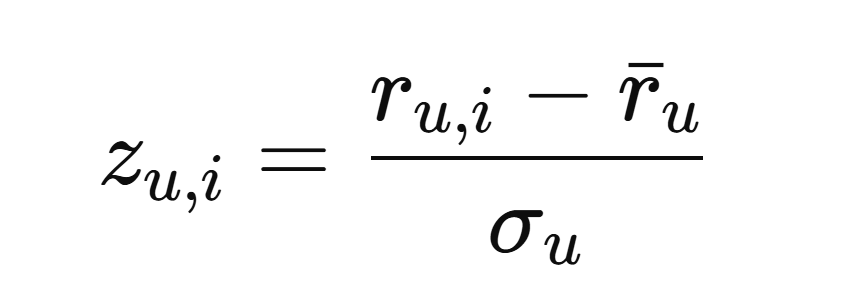

In [ ]:
import math

def z_score_normalization(ratings):
    mean = sum(ratings) / len(ratings)
    std = math.sqrt(sum((r - mean) ** 2 for r in ratings) / len(ratings))
    return [(r - mean) / std for r in ratings] if std != 0 else [0 for _ in ratings]

# Пример
user_ratings = [4, 5, 3, 2]
normalized_z = z_score_normalization(user_ratings)
print(normalized_z)

**Min-Max нормализация**

Приводят оценки к определённому диапазону, например, [0, 1]. Это полезно, когда необходимо сохранить относительный порядок оценок, но привести их к общему масштабу.



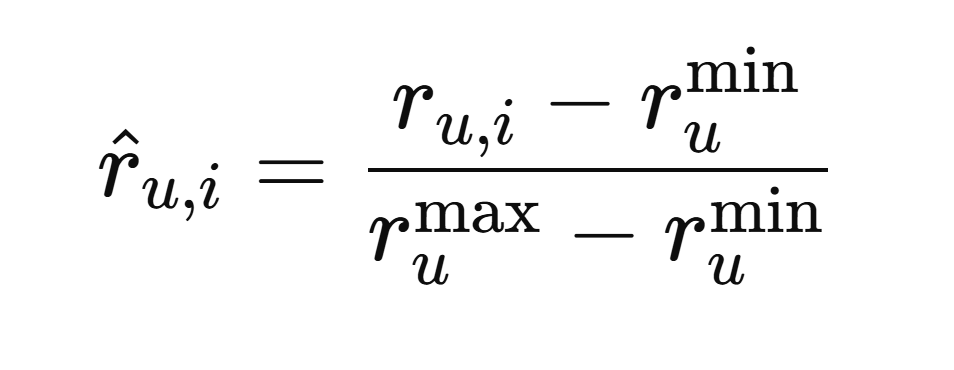

In [ ]:
def min_max_normalization(ratings):
    min_rating = min(ratings)
    max_rating = max(ratings)
    range_rating = max_rating - min_rating
    return [(r - min_rating) / range_rating for r in ratings] if range_rating != 0 else [0 for _ in ratings]

# Пример
user_ratings = [4, 5, 3, 2]
normalized_mm = min_max_normalization(user_ratings)
print(normalized_mm)

**Нормализация с использованием базовых смещений (Baseline normalization)**

Учитывает как систематические отклонения пользователей, так и особенности товаров

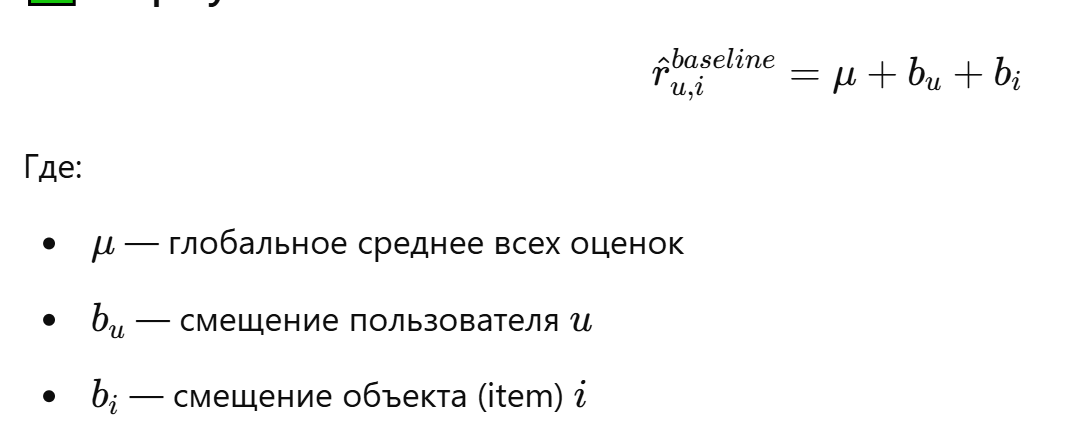

In [ ]:
# Глобальное среднее
global_mean = df['rating'].mean()

# Смещение пользователей
user_bias = df.groupby('user_id')['rating'].mean() - global_mean

# Смещение объектов
item_bias = df.groupby('item_id')['rating'].mean() - global_mean

# Функция для baseline предсказания
def baseline_predict(user_id, item_id):
    bu = user_bias.get(user_id, 0)
    bi = item_bias.get(item_id, 0)
    return global_mean + bu + bi

# Кластеризация

 Для масштабных систем имеет смысл предварительно распределить пользователей по кластерам (например, с помощью алгоритма K-means или иерархической кластеризации) и искать соседей уже внутри кластеров. Это сокращает число вычислений и может повысить релевантность рекомендаций

# Пирсоновская корреляция

Позволяет нивелировать эффект различий в среднем уровне оценок пользователей, сравнивая отклонения от их среднего.
Коэффициент Пирсона (число от -1 до +1). Если общих объектов нет или знаменатель равен 0, возвращается 0.

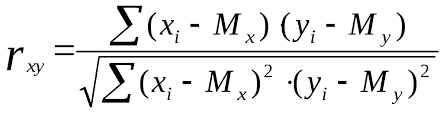

In [ ]:
import math

def pearson_correlation(ratings1: dict, ratings2: dict):

    # Получаем множество общих товаров (объектов), для которых есть оценки у обоих пользователей
    common_items = set(ratings1.keys()).intersection(ratings2.keys())
    n = len(common_items)
    if n == 0:
        # Если нет общих объектов, возвращаем 0 (нет оснований говорить о схожести)
        return 0

    # Вычисляем сумму оценок и сумму квадратов оценок для каждого пользователя по общим объектам
    sum1 = sum(ratings1[item] for item in common_items)
    sum2 = sum(ratings2[item] for item in common_items)

    sum1_sq = sum(ratings1[item] ** 2 for item in common_items)
    sum2_sq = sum(ratings2[item] ** 2 for item in common_items)

    # Сумма произведений оценок
    product_sum = sum(ratings1[item] * ratings2[item] for item in common_items)

    # Вычисляем числитель
    numerator = product_sum - (sum1 * sum2 / n)

    # Вычисляем знаменатель, являющийся произведением стандартных отклонений
    denominator = math.sqrt((sum1_sq - (sum1 ** 2) / n) * (sum2_sq - (sum2 ** 2) / n))

    if denominator == 0:
        return 0
    else:
        return numerator / denominator

user_ratings = {
    "user1": {"item1": 3.5, "item2": 2.0, "item3": 4.5, "item4": 5.0},
    "user2": {"item1": 2.0, "item2": 3.5, "item3": 4.0, "item4": 3.0},
    "user3": {"item1": 5.0, "item2": 3.0, "item3": 3.5, "item4": 4.5}
}

similarity_user1_user2 = pearson_correlation(user_ratings["user1"], user_ratings["user2"])
print("Корреляция Пирсона между user1 и user2:", similarity_user1_user2)


# Косинусное сходство

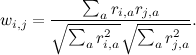

Но для того, чтобы косинус хорошо работал, желательно всё равно сначала вычесть среднее по каждому вектору, так что в реальности это та же самая метрика, что и корреляция Пирсона.

# GroupLens algorithm

Взвешенная оценка для каждого предмета

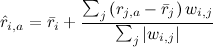

In [ ]:
def predict_ratings_all(user_id, user_item_matrix, similarity_df):
    user_ratings = user_item_matrix.loc[user_id]
    unrated_items = user_ratings[user_ratings == 0].index

    predictions = {}
    for item in unrated_items:
        # Только пользователи, которые оценили item
        rated_by = user_item_matrix[user_item_matrix[item] > 0]
        sims = similarity_df.loc[user_id, rated_by.index]
        ratings = rated_by[item]
        if sims.sum() != 0:
            pred = np.dot(sims, ratings) / sims.sum()
            predictions[item] = pred
    return predictions

Чаще всего используют ту же формулу, но по суженному количеству данных например до k ближайших соседей – k пользователей, максимально похожих на данного пользователя и уже оценивших этот продукт. Потому что в реальности пользователей слишком много.

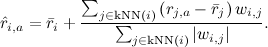

In [ ]:
# Используем корреляцию Пирсона (1 - similarity → distance)
user_similarity = 1 - pairwise_distances(user_item_matrix, metric='correlation')
user_similarity = np.nan_to_num(user_similarity)  # заменим NaN на 0
similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [ ]:
#
similar_users = similarity_df.loc[user_id].sort_values(ascending=False).drop(user_id).head(k)

# Jaccard Index

Индекс варьируется от 0 до 1, чем ближе значение к 1, тем более похожи между собой вектора


Jaccard Similarity = (number of observations in both sets) / (number in either set)

In [ ]:
import numpy as np

a = [0, 1, 2, 5, 6, 8, 9]
b = [0, 2, 3, 4, 5, 7, 9]

In [ ]:
#define Jaccard Similarity function
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#find Jaccard Similarity between the two sets
jaccard(a, b)

In [ ]:
# Пример набора данных: словарь, где ключ – идентификатор пользователя,
# а значение – множество идентификаторов товаров, с которыми пользователь взаимодействовал.
user_items = {
    "user1": {"item1", "item2", "item3"},
    "user2": {"item2", "item3", "item4"},
    "user3": {"item1", "item4", "item5"},
    "user4": {"item2", "item5", "item6"}
}

def jaccard_similarity(set_a, set_b):
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)
    if len(union) == 0:
        return 0.0
    return len(intersection) / len(union)

# Выбираем целевого пользователя для которого строим рекомендации:
target_user = "user1"

# Вычисляем схожесть между целевым пользователем и всеми остальными:
similarities = {}
for other_user, items in user_items.items():
    if other_user == target_user:
        continue
    sim = jaccard_similarity(user_items[target_user], items)
    similarities[other_user] = sim

print("Схожесть с пользователями:")
for user, sim in similarities.items():
    print(f"{target_user} <-> {user}: {sim:.2f}")

# Далее можно выбрать ближайших "соседей" (например, пользователей с ненулевой схожестью)
# и рекомендовать товары, которые они оценили, а целевой пользователь ещё нет.
recommended_items = set()
for user, sim in similarities.items():
    if sim > 0:
        # Добавляем товары, которые не содержатся у target_user
        recommended_items |= (user_items[user] - user_items[target_user])

print(f"\nРекомендации для {target_user}: {recommended_items}")
